<a href="https://colab.research.google.com/github/KennethanCeyer/research/blob/master/DL/GAN/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

This code is an implementation for Generative Adversarial Networks (https://arxiv.org/abs/1406.2661).

## Concept

The code is based on the MNIST dataset, and the GAN model is constructed. The overall purpose of the code is to determine whether the fake image generated by the generator model is random Z through a discriminator (1) or fake (0).

### Discriminator

We have a real image, and we have a fake image generated by a random z generator. Through this, we can train the Discriminator model.

### Generator

On the other hand, we can train the Generator based on the discriminator learned for each step. Since we have a discriminator model that has been trained to some extent, we train the generator model by obtaining a loss based on how similar the image to the real(1) through the discriminator as a result of learning the z-vector generated at random using the generator.

---

Each epoch can learn Discriminator and Generator through the above procedure.

In [1]:
import torch
from torch import nn
import torch.optim as optimizer
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

batch_size = 64

# latent z vector size
z_dim = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mnist = datasets.MNIST('./data', download=True, transform=transforms.ToTensor()) 
data_loader = DataLoader(mnist, batch_size=batch_size, shuffle=True)

# Utilities

Functions to show the learned image results are predefined as utility functions.

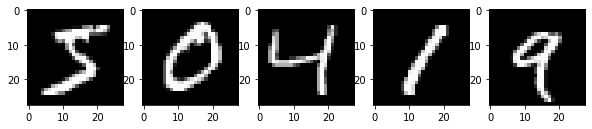

In [27]:
from matplotlib import gridspec
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
from skimage import img_as_ubyte
import numpy as np
import imageio

def show_images(data):
  gs = gridspec.GridSpec(1,5)
  plt.figure(figsize=[10,3])
  for i in range(5):
    plt.subplot(gs[i])
    plt.imshow(data[i][0].squeeze(), cmap='gray')
  plt.show()

def append_gif(img_arr, images):
    img_grid = make_grid(images.data)
    img_grid = np.transpose(img_grid.detach().cpu().numpy(), (1, 2, 0))
    img_grid = img_as_ubyte(img_grid)
    img_arr.append(img_grid)
    imageio.mimsave('./data/generated.gif', img_arr)
    return img_arr

show_images(mnist)

# Generator

Generator generates a fake image by inputting a randomly generated vector z.
We want Generator to produce as realistic an image as possible.

In [28]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        # Three linear layers were formed by increasing the input latent vector z by 2 times.
        # ReLU is used as the activation function,
        # However, in many cases LeakyReLU is used due to DyingReLU where the gradient of the hidden layer disappears,
        # so it can be replaced with LeakyReLU.
        # BatchNorm was applied after every Linear layer was applied to learn by making the batch distribution constant.
        self.layers = []
        self.layers.append(nn.Linear(z_dim, z_dim*2))
        self.layers.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
        self.layers.append(nn.Dropout(0.5))
        self.layers.append(nn.Linear(z_dim*2, z_dim*4))
        self.layers.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
        self.layers.append(nn.Dropout(0.5))
        self.layers.append(nn.Linear(z_dim*4, z_dim*8))
        self.layers.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
        self.layers.append(nn.Dropout(0.5))
        self.layers.append(nn.Linear(z_dim*8, 28*28))
        
        # Since sigmoid is used at the end, it is estimated that the resulting image was slightly blurred.
        # If we change to Tahn, you can create a more clear image.
        self.layers.append(nn.Tanh())
        self.net = nn.Sequential(*self.layers)
                
    def forward(self, x):     
        x = x.view(-1, z_dim)   
        out = self.net(x)
        out = out.view(-1, 1, 28, 28)        
        return out

# Discriminator

Discriminator receives an image as an input and determines whether the image is real(1) or fake(0).
We want the Discriminator to be able to correctly distinguish between real and fake images.

In [29]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layers = []
        self.layers.append(nn.Linear(28*28, z_dim*8))
        self.layers.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
        self.layers.append(nn.Dropout(0.5))
        self.layers.append(nn.Linear(z_dim*8, z_dim*4))
        self.layers.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
        self.layers.append(nn.Dropout(0.5))
        self.layers.append(nn.Linear(z_dim*4, z_dim*2))
        self.layers.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
        self.layers.append(nn.Dropout(0.5))
        self.layers.append(nn.Linear(z_dim*2, 1))
        self.layers.append(nn.Sigmoid())
        self.net = nn.Sequential(*self.layers)

    def forward(self, x):
        x = x.view(-1, 28*28)
        out = self.net(x)
        out = out.view(-1)
        return out

In [30]:
# A parameter variable for the discriminator linear layer was defined.
D = Discriminator().cuda()

# No other parameters are needed for generator learning.
G = Generator().cuda()

# Check the layers of each model.
print(G)
print(D)

Generator(
  (net): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=1024, out_features=784, bias=True)
    (10): Tanh()
  )
)
Discriminator(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): Le

epoch: 1/500, G loss: 4.130617141723633, D loss: 0.4163377285003662
epoch: 2/500, G loss: 3.2117412090301514, D loss: 0.687833845615387
epoch: 3/500, G loss: 2.709580421447754, D loss: 0.6345023512840271
epoch: 4/500, G loss: 2.625835657119751, D loss: 0.7185009121894836
epoch: 5/500, G loss: 2.357067584991455, D loss: 0.7104639410972595
epoch: 6/500, G loss: 3.377986192703247, D loss: 0.3091646730899811
epoch: 7/500, G loss: 3.5523617267608643, D loss: 0.33514896035194397
epoch: 8/500, G loss: 3.9228785037994385, D loss: 0.7630833387374878
epoch: 9/500, G loss: 4.248287200927734, D loss: 0.42074042558670044
epoch: 10/500, G loss: 2.9169344902038574, D loss: 0.3793144226074219
epoch: 11/500, G loss: 3.9495394229888916, D loss: 0.2831456661224365
epoch: 12/500, G loss: 3.87673282623291, D loss: 0.412861168384552
epoch: 13/500, G loss: 3.2005083560943604, D loss: 0.3928806483745575
epoch: 14/500, G loss: 3.093043804168701, D loss: 0.339126855134964
epoch: 15/500, G loss: 3.74817991256713

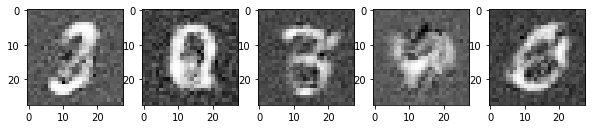

epoch: 21/500, G loss: 3.7832083702087402, D loss: 0.587247908115387
epoch: 22/500, G loss: 3.422337532043457, D loss: 0.4402485489845276
epoch: 23/500, G loss: 4.041542053222656, D loss: 0.29176604747772217
epoch: 24/500, G loss: 4.8704376220703125, D loss: 0.378909170627594
epoch: 25/500, G loss: 4.438899993896484, D loss: 0.49224597215652466
epoch: 26/500, G loss: 3.410134792327881, D loss: 0.32790446281433105
epoch: 27/500, G loss: 3.605775833129883, D loss: 0.5988505482673645
epoch: 28/500, G loss: 4.508261680603027, D loss: 0.3890419602394104
epoch: 29/500, G loss: 3.9896578788757324, D loss: 0.34896907210350037
epoch: 30/500, G loss: 3.6523795127868652, D loss: 0.6568735837936401
epoch: 31/500, G loss: 4.793185234069824, D loss: 0.5362149477005005
epoch: 32/500, G loss: 3.8463945388793945, D loss: 0.2010093331336975
epoch: 33/500, G loss: 4.398945331573486, D loss: 0.1531853824853897
epoch: 34/500, G loss: 5.116629600524902, D loss: 0.22825975716114044
epoch: 35/500, G loss: 4.3

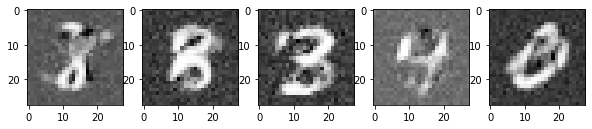

epoch: 41/500, G loss: 4.608019828796387, D loss: 0.32009798288345337
epoch: 42/500, G loss: 4.287974834442139, D loss: 0.38168036937713623
epoch: 43/500, G loss: 4.075221538543701, D loss: 0.3639583885669708
epoch: 44/500, G loss: 5.356768608093262, D loss: 0.16100803017616272
epoch: 45/500, G loss: 4.110274791717529, D loss: 0.4272875487804413
epoch: 46/500, G loss: 4.463249206542969, D loss: 0.2834397852420807
epoch: 47/500, G loss: 4.239082336425781, D loss: 0.20613542199134827
epoch: 48/500, G loss: 5.384695053100586, D loss: 0.21718744933605194
epoch: 49/500, G loss: 4.340558052062988, D loss: 0.422235906124115
epoch: 50/500, G loss: 4.861125946044922, D loss: 0.3198058605194092
epoch: 51/500, G loss: 5.415064811706543, D loss: 0.23893871903419495
epoch: 52/500, G loss: 5.037477493286133, D loss: 0.21425628662109375
epoch: 53/500, G loss: 3.404404401779175, D loss: 0.43393123149871826
epoch: 54/500, G loss: 5.264584541320801, D loss: 0.11335209757089615
epoch: 55/500, G loss: 3.8

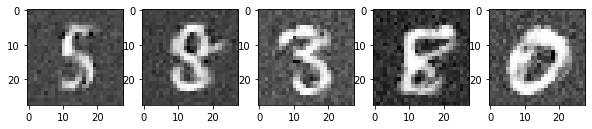

epoch: 61/500, G loss: 5.840502738952637, D loss: 0.2167748361825943
epoch: 62/500, G loss: 3.6706252098083496, D loss: 0.3882257342338562
epoch: 63/500, G loss: 4.8558149337768555, D loss: 0.07243596017360687
epoch: 64/500, G loss: 4.347433090209961, D loss: 0.3940490186214447
epoch: 65/500, G loss: 5.752774238586426, D loss: 0.09145627915859222
epoch: 66/500, G loss: 4.709671497344971, D loss: 0.4139916002750397
epoch: 67/500, G loss: 4.822059631347656, D loss: 0.1298595368862152
epoch: 68/500, G loss: 3.3320343494415283, D loss: 0.5180878639221191
epoch: 69/500, G loss: 4.705710411071777, D loss: 0.13339102268218994
epoch: 70/500, G loss: 4.344443321228027, D loss: 0.2773176431655884
epoch: 71/500, G loss: 5.245584011077881, D loss: 0.25074732303619385
epoch: 72/500, G loss: 4.626547336578369, D loss: 0.19188210368156433
epoch: 73/500, G loss: 5.9751176834106445, D loss: 0.1725357621908188
epoch: 74/500, G loss: 3.267131805419922, D loss: 0.544283390045166
epoch: 75/500, G loss: 4.5

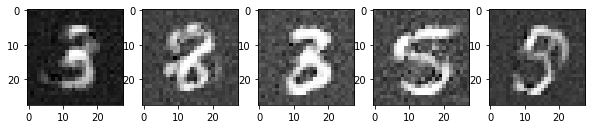

epoch: 81/500, G loss: 4.039608001708984, D loss: 0.15738601982593536
epoch: 82/500, G loss: 5.595637321472168, D loss: 0.17595252394676208
epoch: 83/500, G loss: 5.176443576812744, D loss: 0.16584599018096924
epoch: 84/500, G loss: 4.196365833282471, D loss: 0.11546498537063599
epoch: 85/500, G loss: 4.649041652679443, D loss: 0.06305964291095734
epoch: 86/500, G loss: 5.561629295349121, D loss: 0.15861403942108154
epoch: 87/500, G loss: 5.867906093597412, D loss: 0.1746935248374939
epoch: 88/500, G loss: 4.060847282409668, D loss: 0.21252533793449402
epoch: 89/500, G loss: 5.863702297210693, D loss: 0.09122395515441895
epoch: 90/500, G loss: 6.141260147094727, D loss: 0.044249482452869415
epoch: 91/500, G loss: 5.776324272155762, D loss: 0.25306808948516846
epoch: 92/500, G loss: 4.868786811828613, D loss: 0.1415659487247467
epoch: 93/500, G loss: 5.832302570343018, D loss: 0.235586017370224
epoch: 94/500, G loss: 5.533644676208496, D loss: 0.11467039585113525
epoch: 95/500, G loss: 

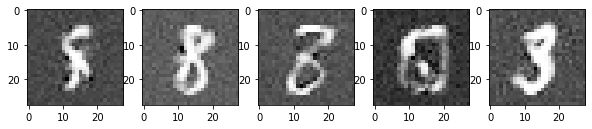

epoch: 101/500, G loss: 5.582022666931152, D loss: 0.19736379384994507
epoch: 102/500, G loss: 4.083208084106445, D loss: 0.30118805170059204
epoch: 103/500, G loss: 4.282910346984863, D loss: 0.0908973291516304
epoch: 104/500, G loss: 4.551070213317871, D loss: 0.1260336935520172
epoch: 105/500, G loss: 4.90275764465332, D loss: 0.18330243229866028
epoch: 106/500, G loss: 5.38090705871582, D loss: 0.10622967779636383
epoch: 107/500, G loss: 6.350135803222656, D loss: 0.17475064098834991
epoch: 108/500, G loss: 5.633896350860596, D loss: 0.2001228630542755
epoch: 109/500, G loss: 5.37312126159668, D loss: 0.09787590056657791
epoch: 110/500, G loss: 3.6371352672576904, D loss: 0.12513680756092072
epoch: 111/500, G loss: 4.718043327331543, D loss: 0.4012017846107483
epoch: 112/500, G loss: 5.096157073974609, D loss: 0.2929348945617676
epoch: 113/500, G loss: 6.463513374328613, D loss: 0.2000458836555481
epoch: 114/500, G loss: 5.085308074951172, D loss: 0.15365058183670044
epoch: 115/500

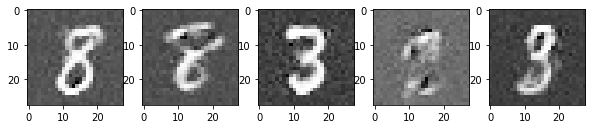

epoch: 121/500, G loss: 4.344520568847656, D loss: 0.14108960330486298
epoch: 122/500, G loss: 4.719819068908691, D loss: 0.41443729400634766
epoch: 123/500, G loss: 4.968440532684326, D loss: 0.26925891637802124
epoch: 124/500, G loss: 5.386074066162109, D loss: 0.22376129031181335
epoch: 125/500, G loss: 5.001182556152344, D loss: 0.18960356712341309
epoch: 126/500, G loss: 6.200682640075684, D loss: 0.12633098661899567
epoch: 127/500, G loss: 5.619139671325684, D loss: 0.11568766087293625
epoch: 128/500, G loss: 5.8591508865356445, D loss: 0.1624584048986435
epoch: 129/500, G loss: 5.318841934204102, D loss: 0.17480304837226868
epoch: 130/500, G loss: 5.43697452545166, D loss: 0.11429080367088318
epoch: 131/500, G loss: 5.878415107727051, D loss: 0.061698101460933685
epoch: 132/500, G loss: 5.787052154541016, D loss: 0.04638290032744408
epoch: 133/500, G loss: 6.397342681884766, D loss: 0.19970548152923584
epoch: 134/500, G loss: 5.675177097320557, D loss: 0.08928628265857697
epoch:

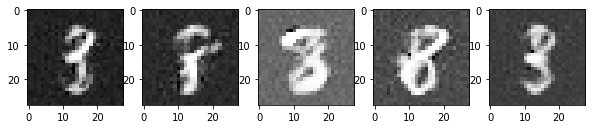

epoch: 141/500, G loss: 4.812950611114502, D loss: 0.18476048111915588
epoch: 142/500, G loss: 4.7013726234436035, D loss: 0.18958619236946106
epoch: 143/500, G loss: 5.32443380355835, D loss: 0.04611790180206299
epoch: 144/500, G loss: 6.4868059158325195, D loss: 0.06673111021518707
epoch: 145/500, G loss: 5.620989799499512, D loss: 0.1472853422164917
epoch: 146/500, G loss: 5.719940185546875, D loss: 0.31168031692504883
epoch: 147/500, G loss: 5.449063301086426, D loss: 0.22584663331508636
epoch: 148/500, G loss: 5.767734527587891, D loss: 0.14150166511535645
epoch: 149/500, G loss: 5.7567596435546875, D loss: 0.11438393592834473
epoch: 150/500, G loss: 4.196163177490234, D loss: 0.2827630043029785
epoch: 151/500, G loss: 4.872062683105469, D loss: 0.11124596744775772
epoch: 152/500, G loss: 5.3975725173950195, D loss: 0.17399439215660095
epoch: 153/500, G loss: 6.078428268432617, D loss: 0.23808971047401428
epoch: 154/500, G loss: 4.110698699951172, D loss: 0.10949766635894775
epoch

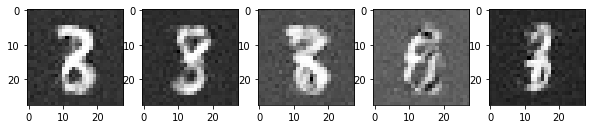

epoch: 161/500, G loss: 4.999485969543457, D loss: 0.07185639441013336
epoch: 162/500, G loss: 6.690821647644043, D loss: 0.1903730034828186
epoch: 163/500, G loss: 6.569962501525879, D loss: 0.21230429410934448
epoch: 164/500, G loss: 4.5918121337890625, D loss: 0.10751435160636902
epoch: 165/500, G loss: 6.517817497253418, D loss: 0.17033176124095917
epoch: 166/500, G loss: 6.568706512451172, D loss: 0.13479800522327423
epoch: 167/500, G loss: 6.0955963134765625, D loss: 0.26292741298675537
epoch: 168/500, G loss: 5.281446933746338, D loss: 0.08313386142253876
epoch: 169/500, G loss: 4.587273597717285, D loss: 0.31789180636405945
epoch: 170/500, G loss: 5.39155912399292, D loss: 0.1084524616599083
epoch: 171/500, G loss: 6.08249568939209, D loss: 0.14311274886131287
epoch: 172/500, G loss: 6.440765380859375, D loss: 0.014765972271561623
epoch: 173/500, G loss: 4.452199935913086, D loss: 0.262917160987854
epoch: 174/500, G loss: 5.612644195556641, D loss: 0.21154674887657166
epoch: 17

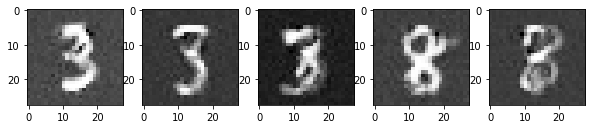

epoch: 181/500, G loss: 6.140111923217773, D loss: 0.3056473433971405
epoch: 182/500, G loss: 6.525825500488281, D loss: 0.2222399264574051
epoch: 183/500, G loss: 6.9539313316345215, D loss: 0.11042939871549606
epoch: 184/500, G loss: 6.5137858390808105, D loss: 0.034809403121471405
epoch: 185/500, G loss: 6.32754373550415, D loss: 0.03148169815540314
epoch: 186/500, G loss: 5.785649299621582, D loss: 0.11689312756061554
epoch: 187/500, G loss: 5.6215105056762695, D loss: 0.07553823292255402
epoch: 188/500, G loss: 5.311122417449951, D loss: 0.013822561129927635
epoch: 189/500, G loss: 6.057305335998535, D loss: 0.1948133409023285
epoch: 190/500, G loss: 5.915019512176514, D loss: 0.07634889334440231
epoch: 191/500, G loss: 4.276241779327393, D loss: 0.14318270981311798
epoch: 192/500, G loss: 6.955262184143066, D loss: 0.09203804284334183
epoch: 193/500, G loss: 6.866937637329102, D loss: 0.10246738791465759
epoch: 194/500, G loss: 5.9029011726379395, D loss: 0.03193803131580353
epoc

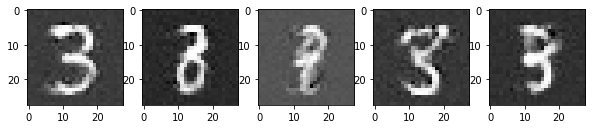

epoch: 201/500, G loss: 5.598226070404053, D loss: 0.13784684240818024
epoch: 202/500, G loss: 5.814555644989014, D loss: 0.021323783323168755
epoch: 203/500, G loss: 8.324118614196777, D loss: 0.05950961634516716
epoch: 204/500, G loss: 5.652984619140625, D loss: 0.11767309904098511
epoch: 205/500, G loss: 4.692925453186035, D loss: 0.15817363560199738
epoch: 206/500, G loss: 6.49862003326416, D loss: 0.15235671401023865
epoch: 207/500, G loss: 6.358887672424316, D loss: 0.07874247431755066
epoch: 208/500, G loss: 4.761013984680176, D loss: 0.28662222623825073
epoch: 209/500, G loss: 5.216107368469238, D loss: 0.13908278942108154
epoch: 210/500, G loss: 5.174928188323975, D loss: 0.15624293684959412
epoch: 211/500, G loss: 6.619332790374756, D loss: 0.0181106049567461
epoch: 212/500, G loss: 4.874153137207031, D loss: 0.2760043144226074
epoch: 213/500, G loss: 6.80068302154541, D loss: 0.14461997151374817
epoch: 214/500, G loss: 6.753779888153076, D loss: 0.14220000803470612
epoch: 21

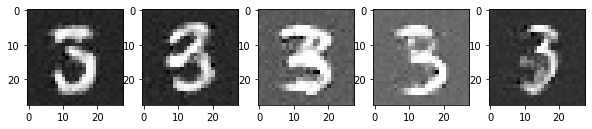

epoch: 221/500, G loss: 6.386932849884033, D loss: 0.06330199539661407
epoch: 222/500, G loss: 6.875455856323242, D loss: 0.01572338491678238
epoch: 223/500, G loss: 7.407264709472656, D loss: 0.24944835901260376
epoch: 224/500, G loss: 5.7288713455200195, D loss: 0.06441107392311096
epoch: 225/500, G loss: 5.978336334228516, D loss: 0.1149183064699173
epoch: 226/500, G loss: 5.4367756843566895, D loss: 0.13347914814949036
epoch: 227/500, G loss: 6.760509967803955, D loss: 0.20238272845745087
epoch: 228/500, G loss: 5.423645973205566, D loss: 0.025948263704776764
epoch: 229/500, G loss: 5.763761520385742, D loss: 0.08621963858604431
epoch: 230/500, G loss: 4.893232822418213, D loss: 0.07845288515090942
epoch: 231/500, G loss: 6.99826717376709, D loss: 0.025174293667078018
epoch: 232/500, G loss: 6.382258415222168, D loss: 0.16590838134288788
epoch: 233/500, G loss: 6.10713529586792, D loss: 0.08064243197441101
epoch: 234/500, G loss: 6.343755722045898, D loss: 0.015445077791810036
epoc

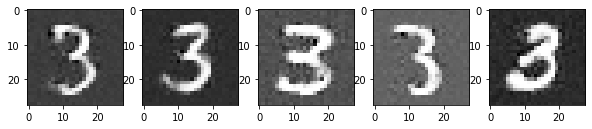

epoch: 241/500, G loss: 6.227729797363281, D loss: 0.16857661306858063
epoch: 242/500, G loss: 5.119338035583496, D loss: 0.06777902692556381
epoch: 243/500, G loss: 7.962162017822266, D loss: 0.13591669499874115
epoch: 244/500, G loss: 6.201757907867432, D loss: 0.16807731986045837
epoch: 245/500, G loss: 6.896649360656738, D loss: 0.010303189978003502
epoch: 246/500, G loss: 7.17352294921875, D loss: 0.018795259296894073
epoch: 247/500, G loss: 5.807375907897949, D loss: 0.11253365874290466
epoch: 248/500, G loss: 6.544927597045898, D loss: 0.041227567940950394
epoch: 249/500, G loss: 6.359156608581543, D loss: 0.017252983525395393
epoch: 250/500, G loss: 5.217090606689453, D loss: 0.037001751363277435
epoch: 251/500, G loss: 5.545379161834717, D loss: 0.2544706463813782
epoch: 252/500, G loss: 5.975645065307617, D loss: 0.22882628440856934
epoch: 253/500, G loss: 6.128475189208984, D loss: 0.00935090146958828
epoch: 254/500, G loss: 7.600762367248535, D loss: 0.016251947730779648
ep

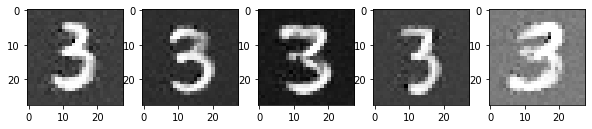

epoch: 261/500, G loss: 7.019582748413086, D loss: 0.04372309893369675
epoch: 262/500, G loss: 6.511978626251221, D loss: 0.23123818635940552
epoch: 263/500, G loss: 5.521564483642578, D loss: 0.1266200691461563
epoch: 264/500, G loss: 5.681263446807861, D loss: 0.1740577071905136
epoch: 265/500, G loss: 6.370811462402344, D loss: 0.1378180831670761
epoch: 266/500, G loss: 5.820511817932129, D loss: 0.11825857311487198
epoch: 267/500, G loss: 6.036014556884766, D loss: 0.028133230283856392
epoch: 268/500, G loss: 6.215620040893555, D loss: 0.17761985957622528
epoch: 269/500, G loss: 6.989418983459473, D loss: 0.18001621961593628
epoch: 270/500, G loss: 6.01710319519043, D loss: 0.10300511121749878
epoch: 271/500, G loss: 6.447667121887207, D loss: 0.024037662893533707
epoch: 272/500, G loss: 6.655388832092285, D loss: 0.0880323275923729
epoch: 273/500, G loss: 6.743144989013672, D loss: 0.021960895508527756
epoch: 274/500, G loss: 7.020557403564453, D loss: 0.08593129366636276
epoch: 2

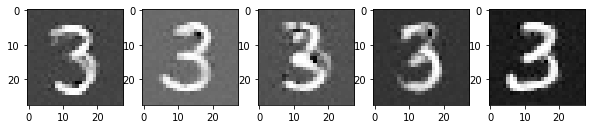

epoch: 281/500, G loss: 7.471397399902344, D loss: 0.003435188438743353
epoch: 282/500, G loss: 6.396778106689453, D loss: 0.014633743092417717
epoch: 283/500, G loss: 6.814131736755371, D loss: 0.008076139725744724
epoch: 284/500, G loss: 4.835213661193848, D loss: 0.15013602375984192
epoch: 285/500, G loss: 6.285495281219482, D loss: 0.022815866395831108
epoch: 286/500, G loss: 7.168573379516602, D loss: 0.0077555375173687935
epoch: 287/500, G loss: 7.667989253997803, D loss: 0.006711247377097607
epoch: 288/500, G loss: 6.591520309448242, D loss: 0.015563767403364182
epoch: 289/500, G loss: 6.049533843994141, D loss: 0.3021814227104187
epoch: 290/500, G loss: 6.126522064208984, D loss: 0.012604691088199615
epoch: 291/500, G loss: 8.333489418029785, D loss: 0.11922487616539001
epoch: 292/500, G loss: 6.534453392028809, D loss: 0.09918439388275146
epoch: 293/500, G loss: 6.923118591308594, D loss: 0.010888529010117054
epoch: 294/500, G loss: 7.039242744445801, D loss: 0.009763077832758

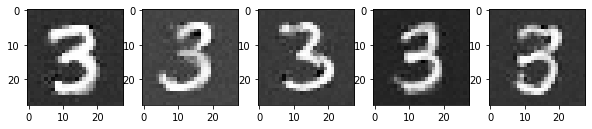

epoch: 301/500, G loss: 6.956704139709473, D loss: 0.008620282635092735
epoch: 302/500, G loss: 6.533667087554932, D loss: 0.056049421429634094
epoch: 303/500, G loss: 7.476218223571777, D loss: 0.03402576968073845
epoch: 304/500, G loss: 7.023505210876465, D loss: 0.015167037956416607
epoch: 305/500, G loss: 7.3967742919921875, D loss: 0.038714878261089325
epoch: 306/500, G loss: 8.38082218170166, D loss: 0.009271646849811077
epoch: 307/500, G loss: 6.946956634521484, D loss: 0.0168776772916317
epoch: 308/500, G loss: 7.689153671264648, D loss: 0.10433721542358398
epoch: 309/500, G loss: 6.188968658447266, D loss: 0.12762542068958282
epoch: 310/500, G loss: 6.1771345138549805, D loss: 0.10395058989524841
epoch: 311/500, G loss: 6.314408302307129, D loss: 0.2104429006576538
epoch: 312/500, G loss: 6.369963645935059, D loss: 0.0366714671254158
epoch: 313/500, G loss: 7.621906280517578, D loss: 0.02430626004934311
epoch: 314/500, G loss: 7.707456588745117, D loss: 0.05102384462952614
epo

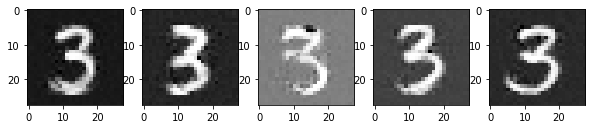

epoch: 321/500, G loss: 7.155802249908447, D loss: 0.009952886030077934
epoch: 322/500, G loss: 6.6614580154418945, D loss: 0.030456358566880226
epoch: 323/500, G loss: 6.936471939086914, D loss: 0.038684070110321045
epoch: 324/500, G loss: 7.235258102416992, D loss: 0.012261098250746727
epoch: 325/500, G loss: 6.866005897521973, D loss: 0.02351483702659607
epoch: 326/500, G loss: 7.606314659118652, D loss: 0.04442210495471954
epoch: 327/500, G loss: 6.051729679107666, D loss: 0.13047027587890625
epoch: 328/500, G loss: 6.361376762390137, D loss: 0.06946446746587753
epoch: 329/500, G loss: 6.1189470291137695, D loss: 0.02090820111334324
epoch: 330/500, G loss: 6.336430549621582, D loss: 0.06455401331186295
epoch: 331/500, G loss: 6.92218542098999, D loss: 0.05015556886792183
epoch: 332/500, G loss: 5.678099632263184, D loss: 0.22601990401744843
epoch: 333/500, G loss: 10.711162567138672, D loss: 0.02687981352210045
epoch: 334/500, G loss: 6.899664878845215, D loss: 0.01398774329572916


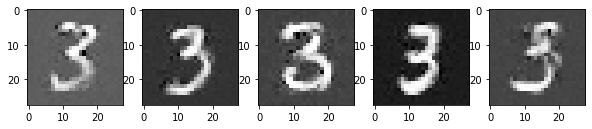

epoch: 341/500, G loss: 7.348662376403809, D loss: 0.015925712883472443
epoch: 342/500, G loss: 7.131080627441406, D loss: 0.03113534115254879
epoch: 343/500, G loss: 7.120699882507324, D loss: 0.014405555091798306
epoch: 344/500, G loss: 7.179821968078613, D loss: 0.12448983639478683
epoch: 345/500, G loss: 8.005535125732422, D loss: 0.18899817764759064
epoch: 346/500, G loss: 7.315252780914307, D loss: 0.022772876545786858
epoch: 347/500, G loss: 7.004965782165527, D loss: 0.02735208347439766
epoch: 348/500, G loss: 9.049554824829102, D loss: 0.024491585791110992
epoch: 349/500, G loss: 6.892861366271973, D loss: 0.017635095864534378
epoch: 350/500, G loss: 6.535978317260742, D loss: 0.08404235541820526
epoch: 351/500, G loss: 7.969679355621338, D loss: 0.010927748866379261
epoch: 352/500, G loss: 7.969461917877197, D loss: 0.012582994066178799
epoch: 353/500, G loss: 9.069701194763184, D loss: 0.03617376089096069
epoch: 354/500, G loss: 7.096109390258789, D loss: 0.00356190465390682

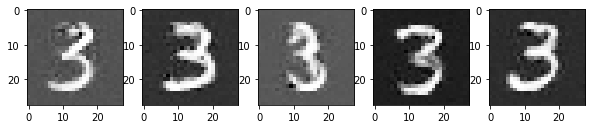

epoch: 361/500, G loss: 9.687540054321289, D loss: 0.0005429241573438048
epoch: 362/500, G loss: 8.079790115356445, D loss: 0.07949787378311157
epoch: 363/500, G loss: 7.394216537475586, D loss: 0.009571443311870098
epoch: 364/500, G loss: 6.088319301605225, D loss: 0.01710713841021061
epoch: 365/500, G loss: 6.95596170425415, D loss: 0.020461423322558403
epoch: 366/500, G loss: 7.073041915893555, D loss: 0.00846509076654911
epoch: 367/500, G loss: 9.365010261535645, D loss: 0.20465943217277527
epoch: 368/500, G loss: 5.847949028015137, D loss: 0.008872881531715393
epoch: 369/500, G loss: 6.25006103515625, D loss: 0.08850917220115662
epoch: 370/500, G loss: 7.707496643066406, D loss: 0.023310784250497818
epoch: 371/500, G loss: 7.193597793579102, D loss: 0.10213423520326614
epoch: 372/500, G loss: 7.490689277648926, D loss: 0.02058464102447033
epoch: 373/500, G loss: 7.846409797668457, D loss: 0.007993437349796295
epoch: 374/500, G loss: 6.9789581298828125, D loss: 0.016722962260246277

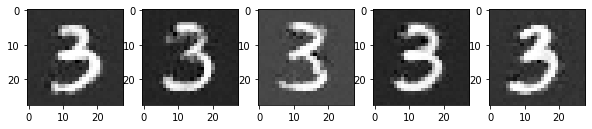

epoch: 381/500, G loss: 8.44845199584961, D loss: 0.001944939256645739
epoch: 382/500, G loss: 7.9525933265686035, D loss: 0.13841283321380615
epoch: 383/500, G loss: 7.184332847595215, D loss: 0.016532160341739655
epoch: 384/500, G loss: 6.033807277679443, D loss: 0.010401930660009384
epoch: 385/500, G loss: 7.1530914306640625, D loss: 0.015984781086444855
epoch: 386/500, G loss: 7.354850769042969, D loss: 0.0848909392952919
epoch: 387/500, G loss: 8.046843528747559, D loss: 0.0328015573322773
epoch: 388/500, G loss: 6.745819091796875, D loss: 0.0027512158267199993
epoch: 389/500, G loss: 6.724154472351074, D loss: 0.1416882574558258
epoch: 390/500, G loss: 7.457040786743164, D loss: 0.01150035485625267
epoch: 391/500, G loss: 7.310530662536621, D loss: 0.04959532618522644
epoch: 392/500, G loss: 9.636594772338867, D loss: 0.0002003120316658169
epoch: 393/500, G loss: 9.019392013549805, D loss: 0.0008066532318480313
epoch: 394/500, G loss: 7.648199081420898, D loss: 0.2338483631610870

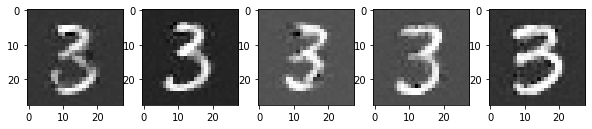

epoch: 401/500, G loss: 7.5973801612854, D loss: 0.024927519261837006
epoch: 402/500, G loss: 8.527512550354004, D loss: 0.035963501781225204
epoch: 403/500, G loss: 6.858960151672363, D loss: 0.025949589908123016
epoch: 404/500, G loss: 6.871459007263184, D loss: 0.05440622568130493
epoch: 405/500, G loss: 7.2989420890808105, D loss: 0.142927885055542
epoch: 406/500, G loss: 8.421523094177246, D loss: 0.21845084428787231
epoch: 407/500, G loss: 6.724207878112793, D loss: 0.030086081475019455
epoch: 408/500, G loss: 9.665958404541016, D loss: 0.008273850195109844
epoch: 409/500, G loss: 8.071123123168945, D loss: 0.10771150887012482
epoch: 410/500, G loss: 6.7146406173706055, D loss: 0.040804702788591385
epoch: 411/500, G loss: 7.495118618011475, D loss: 0.0640026330947876
epoch: 412/500, G loss: 8.62280559539795, D loss: 0.016613656654953957
epoch: 413/500, G loss: 7.186829090118408, D loss: 0.027112601324915886
epoch: 414/500, G loss: 7.690909385681152, D loss: 0.0018862610450014472


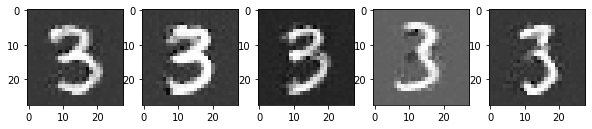

epoch: 421/500, G loss: 6.903502941131592, D loss: 0.03216439113020897
epoch: 422/500, G loss: 7.367937088012695, D loss: 0.09786999225616455
epoch: 423/500, G loss: 7.233555793762207, D loss: 0.07173852622509003
epoch: 424/500, G loss: 7.961686611175537, D loss: 0.04253951460123062
epoch: 425/500, G loss: 7.60504150390625, D loss: 0.04393288493156433
epoch: 426/500, G loss: 8.359943389892578, D loss: 0.016047336161136627
epoch: 427/500, G loss: 9.55096435546875, D loss: 0.0003903085016645491
epoch: 428/500, G loss: 6.606073379516602, D loss: 0.02869667112827301
epoch: 429/500, G loss: 6.634035110473633, D loss: 0.009042320773005486
epoch: 430/500, G loss: 9.337547302246094, D loss: 0.03069823980331421
epoch: 431/500, G loss: 7.66925048828125, D loss: 0.04376450181007385
epoch: 432/500, G loss: 7.515728950500488, D loss: 0.0187404565513134
epoch: 433/500, G loss: 8.02719783782959, D loss: 0.17437899112701416
epoch: 434/500, G loss: 7.314008712768555, D loss: 0.057668544352054596
epoch:

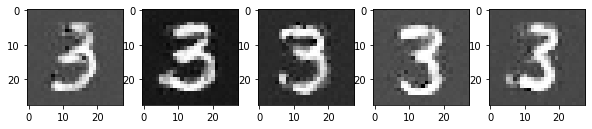

epoch: 441/500, G loss: 7.591032981872559, D loss: 0.0831766352057457
epoch: 442/500, G loss: 7.455448627471924, D loss: 0.08140437304973602
epoch: 443/500, G loss: 7.14914608001709, D loss: 0.08039286732673645
epoch: 444/500, G loss: 6.929292678833008, D loss: 0.00813679676502943
epoch: 445/500, G loss: 6.719205856323242, D loss: 0.06550996005535126
epoch: 446/500, G loss: 6.8900604248046875, D loss: 0.010980576276779175
epoch: 447/500, G loss: 6.21552848815918, D loss: 0.04364054650068283
epoch: 448/500, G loss: 5.6505126953125, D loss: 0.27375757694244385
epoch: 449/500, G loss: 5.096614837646484, D loss: 0.19362324476242065
epoch: 450/500, G loss: 4.086429119110107, D loss: 0.3009442090988159
epoch: 451/500, G loss: 4.7391462326049805, D loss: 0.20467376708984375
epoch: 452/500, G loss: 4.528347015380859, D loss: 0.5502405166625977
epoch: 453/500, G loss: 5.078099250793457, D loss: 0.15830932557582855
epoch: 454/500, G loss: 5.230806350708008, D loss: 0.06320257484912872
epoch: 455

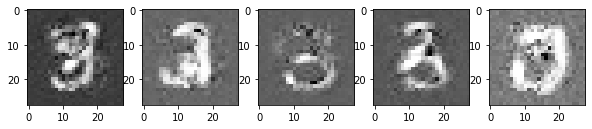

epoch: 461/500, G loss: 5.353666305541992, D loss: 0.20105716586112976
epoch: 462/500, G loss: 5.651453971862793, D loss: 0.4234444797039032
epoch: 463/500, G loss: 6.46769905090332, D loss: 0.1614019274711609
epoch: 464/500, G loss: 4.573154449462891, D loss: 0.34845060110092163
epoch: 465/500, G loss: 6.784680366516113, D loss: 0.039401762187480927
epoch: 466/500, G loss: 6.377098083496094, D loss: 0.08977852761745453
epoch: 467/500, G loss: 5.328032493591309, D loss: 0.1376362293958664
epoch: 468/500, G loss: 6.199524879455566, D loss: 0.15675580501556396
epoch: 469/500, G loss: 6.374073028564453, D loss: 0.01860557124018669
epoch: 470/500, G loss: 6.099058628082275, D loss: 0.12341669946908951
epoch: 471/500, G loss: 5.423053741455078, D loss: 0.028825677931308746
epoch: 472/500, G loss: 6.905560493469238, D loss: 0.12596479058265686
epoch: 473/500, G loss: 5.969707489013672, D loss: 0.039906036108732224
epoch: 474/500, G loss: 7.099569320678711, D loss: 0.08318684995174408
epoch: 

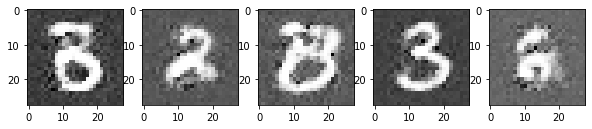

epoch: 481/500, G loss: 5.780303955078125, D loss: 0.1775912344455719
epoch: 482/500, G loss: 6.769597053527832, D loss: 0.11358991265296936
epoch: 483/500, G loss: 5.349735260009766, D loss: 0.21836301684379578
epoch: 484/500, G loss: 6.528476715087891, D loss: 0.08702582120895386
epoch: 485/500, G loss: 6.6305646896362305, D loss: 0.11766675114631653
epoch: 486/500, G loss: 7.541997909545898, D loss: 0.14591945707798004
epoch: 487/500, G loss: 6.704097747802734, D loss: 0.06372016668319702
epoch: 488/500, G loss: 5.419610023498535, D loss: 0.21077704429626465
epoch: 489/500, G loss: 6.261457443237305, D loss: 0.24702060222625732
epoch: 490/500, G loss: 6.978771209716797, D loss: 0.05671614781022072
epoch: 491/500, G loss: 6.885941505432129, D loss: 0.11497166752815247
epoch: 492/500, G loss: 6.725722312927246, D loss: 0.1311766803264618
epoch: 493/500, G loss: 6.665487766265869, D loss: 0.013091063126921654
epoch: 494/500, G loss: 6.535327434539795, D loss: 0.033745571970939636
epoch

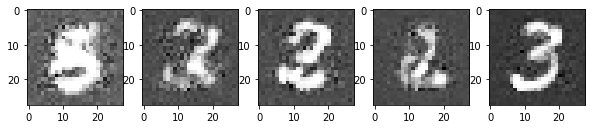

In [31]:
# Generate a random vector z for generating fake images.
fix_z = torch.randn(16, z_dim).cuda() # create 16 numbe of fixed noise in order to show 16 samples
fix_z_images = []

# The optimizer uses Adam.
# Adam optimizes the learning speed according to the parameters, so it can perform learning efficiently.

# The reason is not stated separately, but the discriminator has half the learning rate of the generator.
# It is estimated that this is because the Discriminator is learned through k_steps (2 times) every epoch.
optim_D = optimizer.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_G = optimizer.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Binary cross-entropy is used as the loss function.
# BCE is suitable for judging the difference value according to the label classified as real or fake.
loss = nn.BCELoss() 

# Epoch was set to 100. Since MNIST has a simple form, it does not require many epochs,
# and it is considered that the high epoch is not set for testing purposes.
total_epoch = 500

# Discriminator is performed twice for every epoch.
# Instead of increasing the learning rate,
# I didn't understand exactly what's the benefit of training this way.
k_step = 2  

for i in range(total_epoch):
  for idx, (data, label) in enumerate(data_loader):
      batch_size = data.size(0)
      # The purpose of this section is to put the given real MNIST image and the fake image generated by the generator
      # as input values into the Discriminator model, and use real_label(1) and fake_label(0)
      # to output the real image as real_label and the fake image as fake_label.
      ############# k step start ############
      z = torch.randn(batch_size, z_dim).cuda()
      data = data.cuda()

      # Define a label variable to find the loss function.
      # 1 for real, 0 for fake.
      real_label = torch.ones(batch_size).cuda()
      fake_label = torch.zeros(batch_size).cuda()

      D.zero_grad()

      # output_D is the result of determining the actual image and is derived as 1. The closer to 0, the higher the loss.
      output_D = D(data)

      # output_D_G is the result of determining the image and induces it to 0. The closer to 1, the higher the loss.
      output_D_G = D(G(z).detach())

      # Each loss is calculated based on the result of discrimination between the real image and the fake image, and the final loss is obtained by adding the values.
      loss_D = loss(output_D, real_label) + loss(output_D_G, fake_label)

      # The derivative value is updated by reflecting the loss in the backprop.
      loss_D.backward()
      optim_D.step()
      ############# k step done ############

      # Here, the image generated by the Generator is discriminated by the Discriminator,
      # which was partially trained before, and induced to be created similar to the real(1).

      # Generates a random vector z to provide to the generator.
      z = torch.randn(batch_size, z_dim).cuda()

      G.zero_grad()

      # The label variable real_label(1) is defined to verify what the discriminator really identifies.
      real_label = torch.ones(batch_size).cuda()
      output_D_G = D(G(z))

      # The loss is calculated based on how far the output_D_G differs from the real(1) result of determining the generated image.
      # The closer to 0, the higher the loss value.
      loss_G = loss(output_D_G, real_label)

      # The derivative value is updated by reflecting the loss in the backprop.
      loss_G.backward()
      optim_G.step()
  
  print("epoch: {}/{}, G loss: {}, D loss: {}".format(i+1, total_epoch, loss_G.item(), loss_D.item()))

  ### just to check how images are generated according to epoch 
  fake = G(fix_z)
  fix_z_images = append_gif(fix_z_images, fake) 
  if (i + 1) % 20 == 0:
    show_images(fake.detach().cpu())

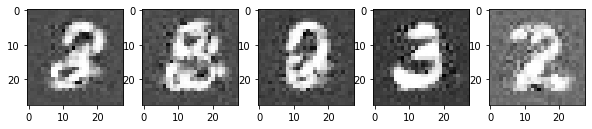

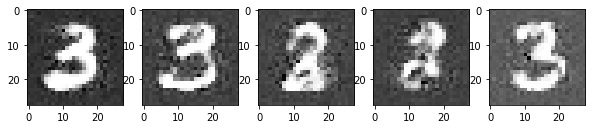

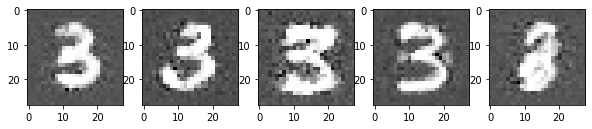

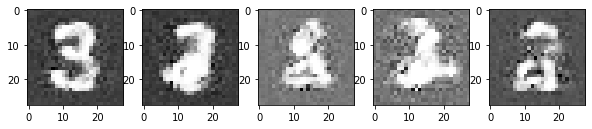

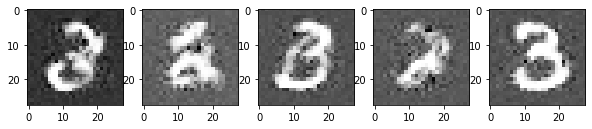

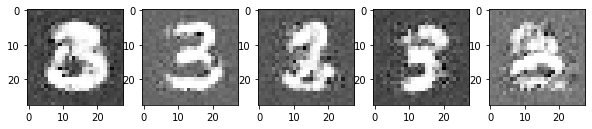

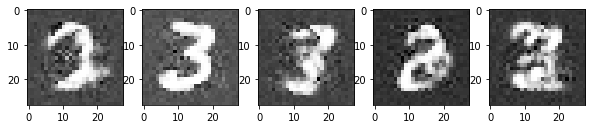

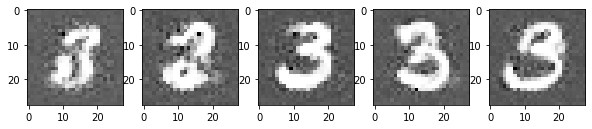

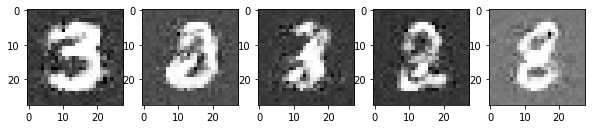

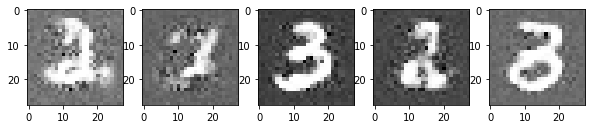

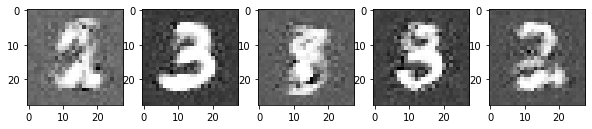

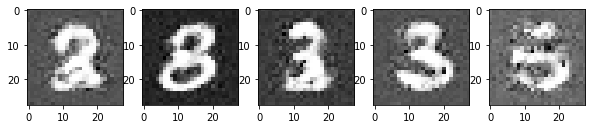

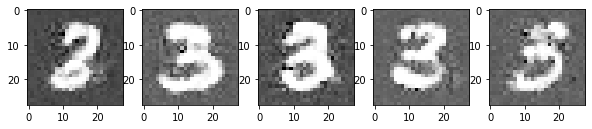

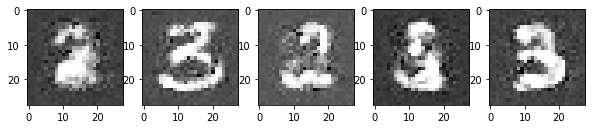

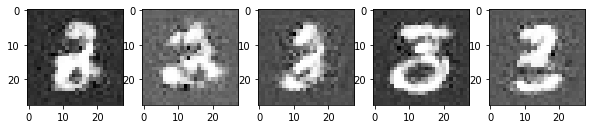

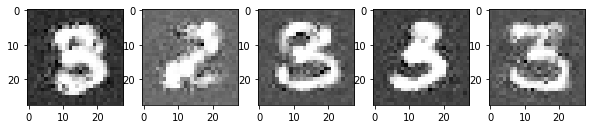

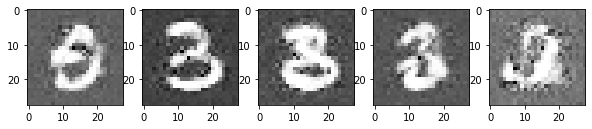

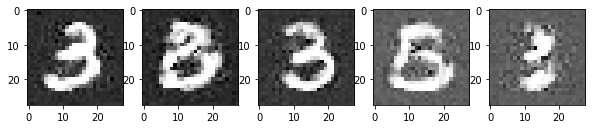

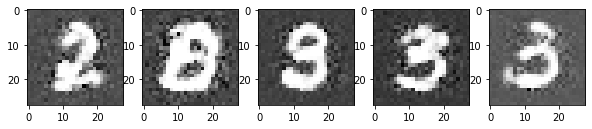

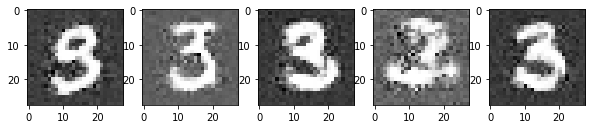

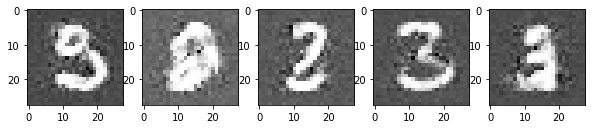

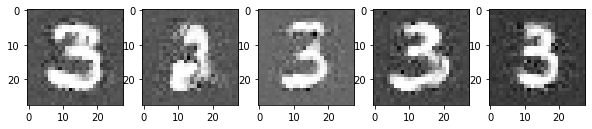

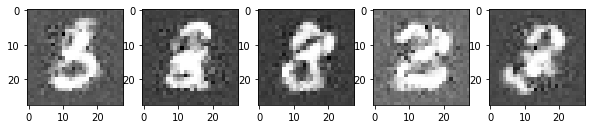

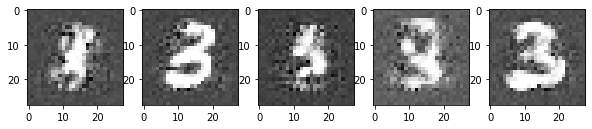

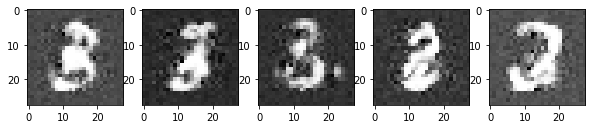

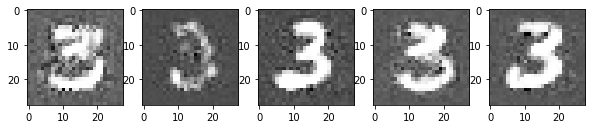

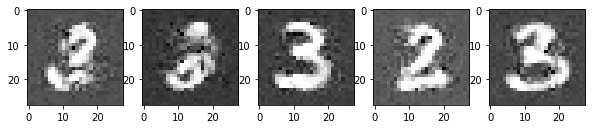

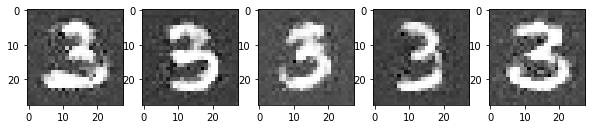

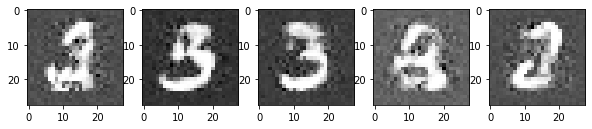

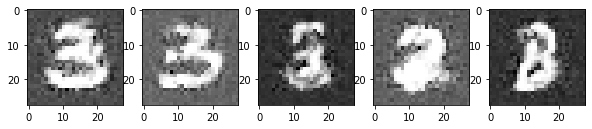

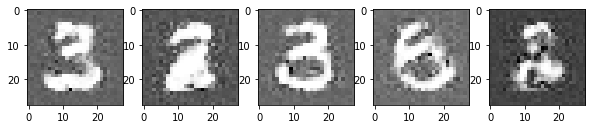

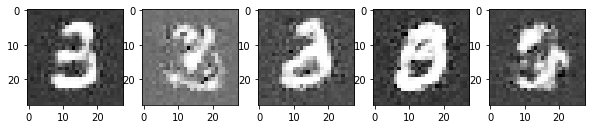

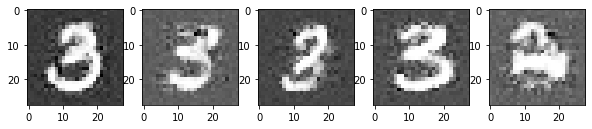

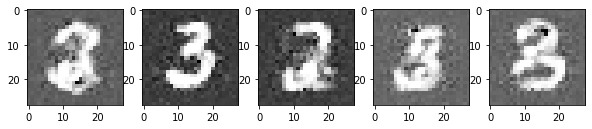

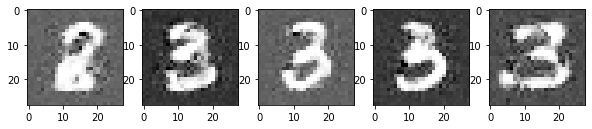

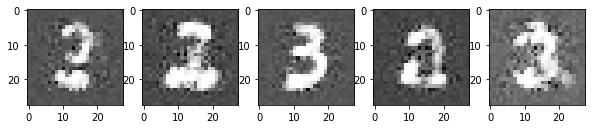

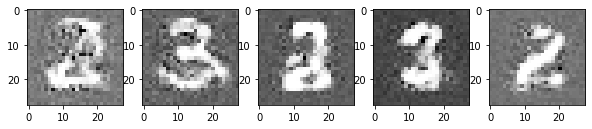

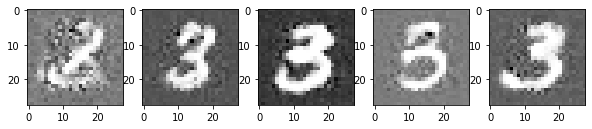

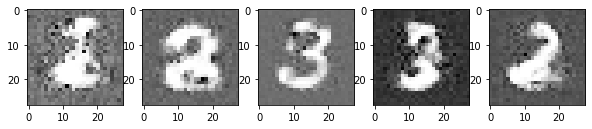

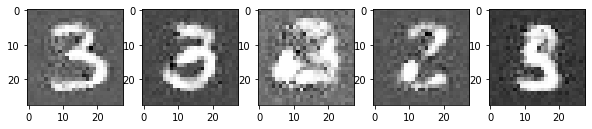

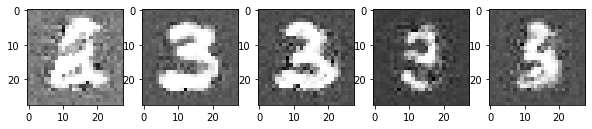

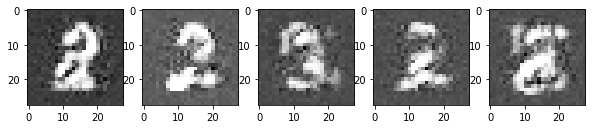

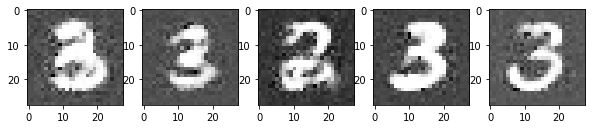

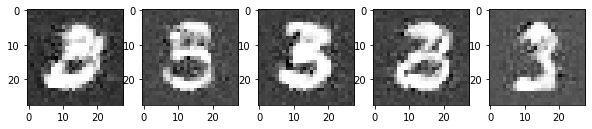

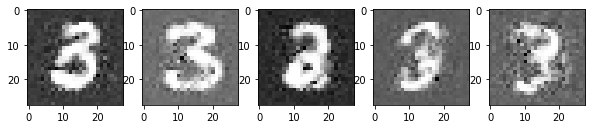

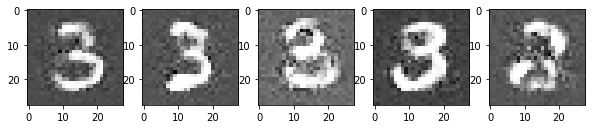

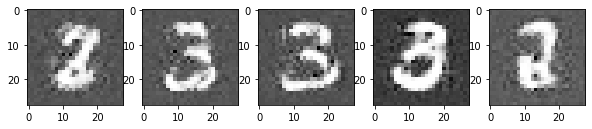

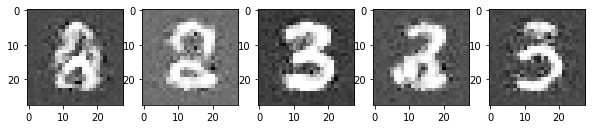

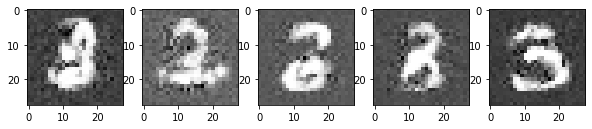

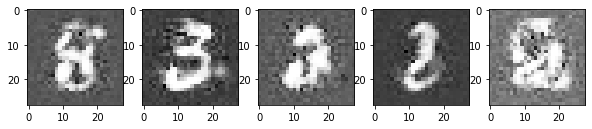

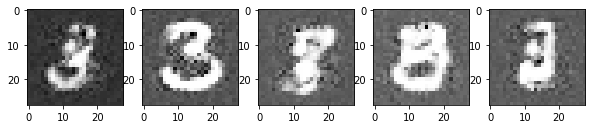

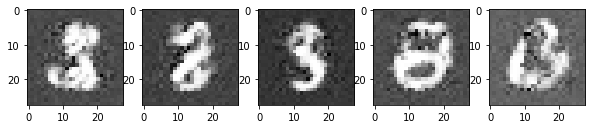

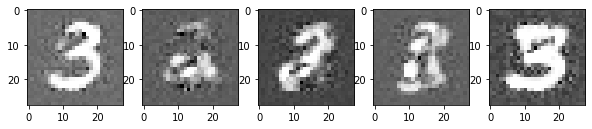

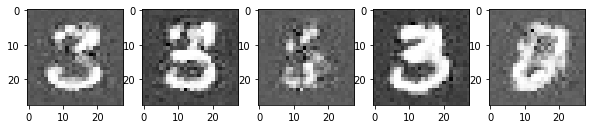

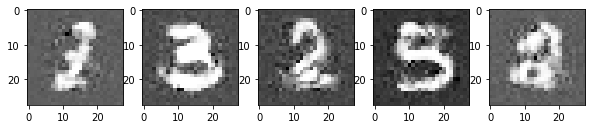

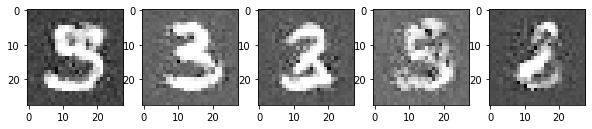

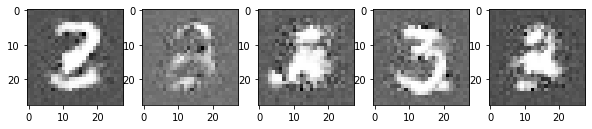

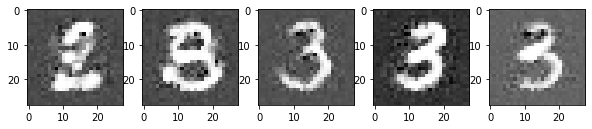

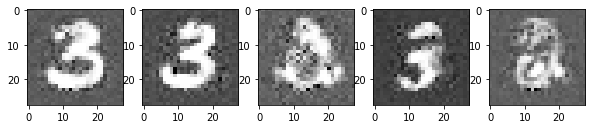

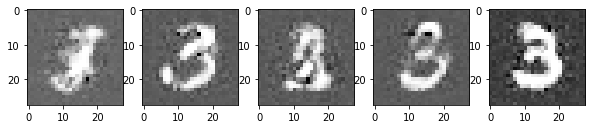

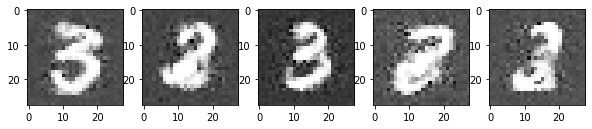

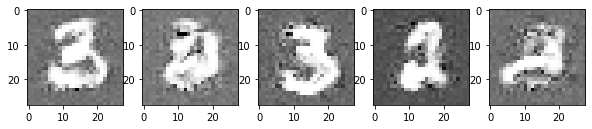

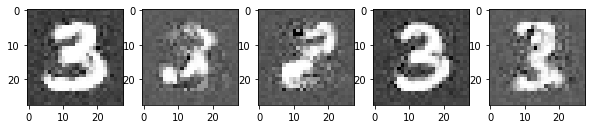

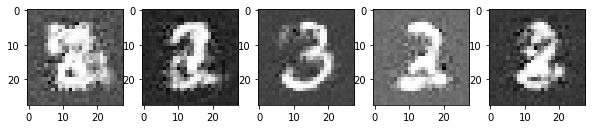

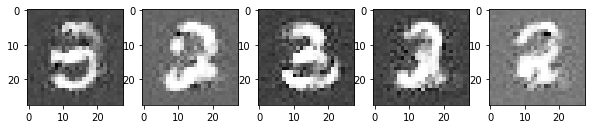

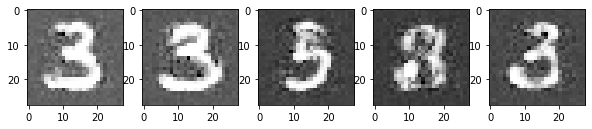

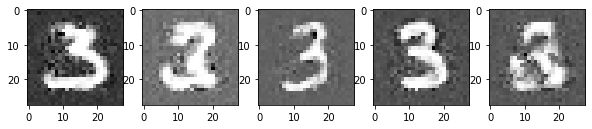

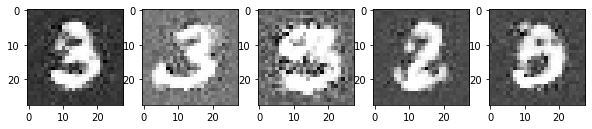

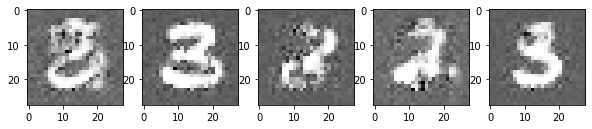

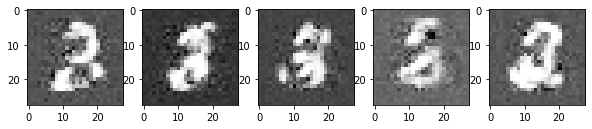

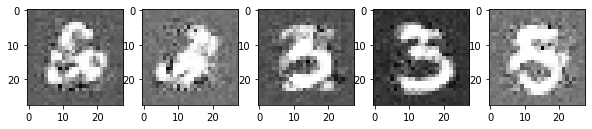

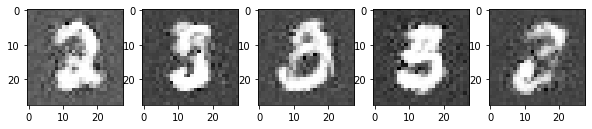

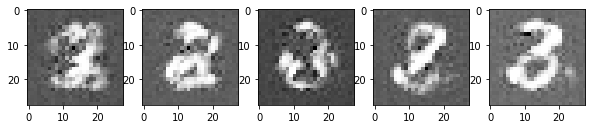

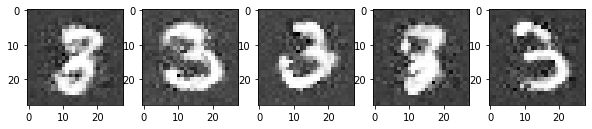

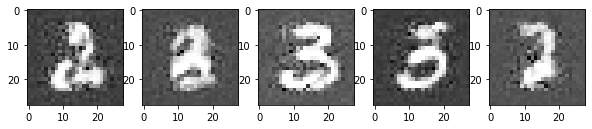

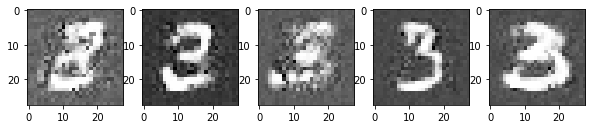

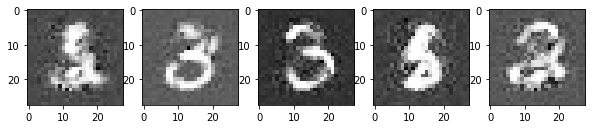

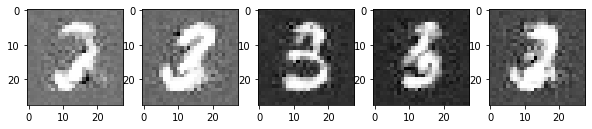

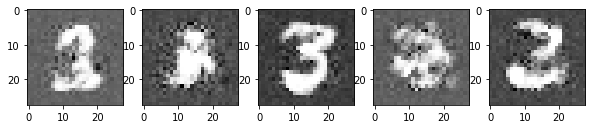

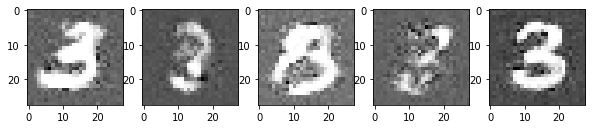

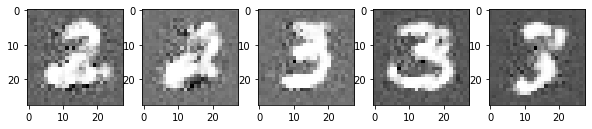

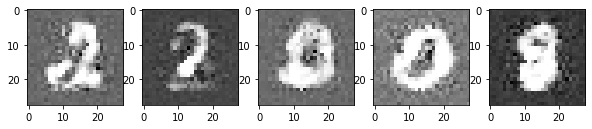

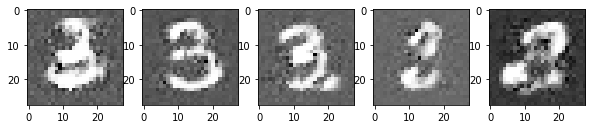

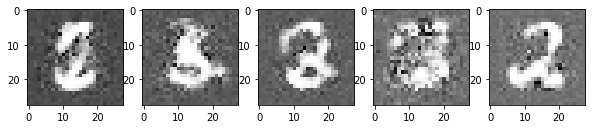

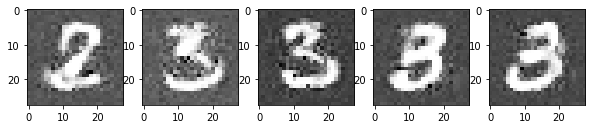

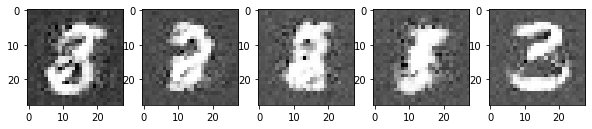

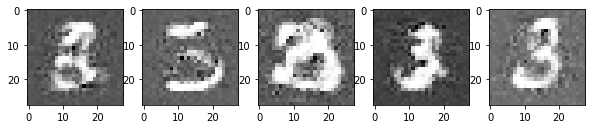

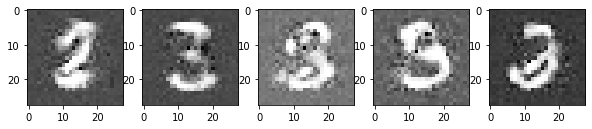

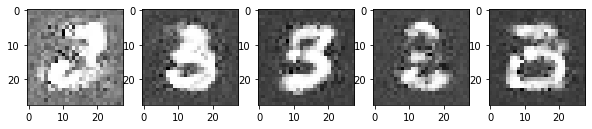

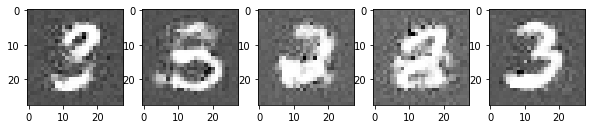

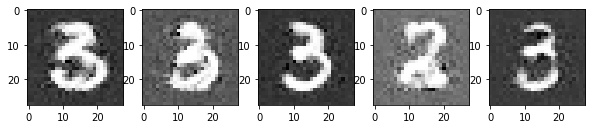

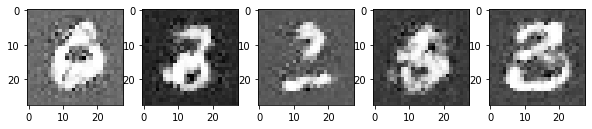

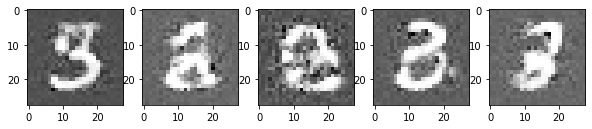

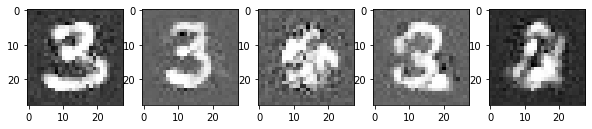

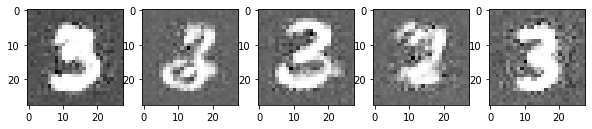

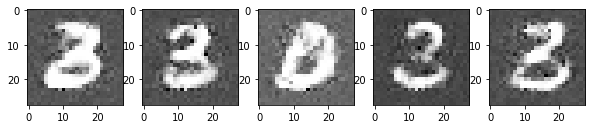

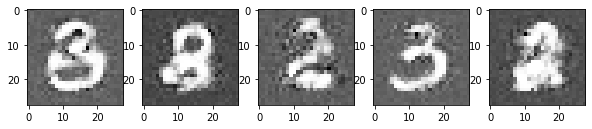

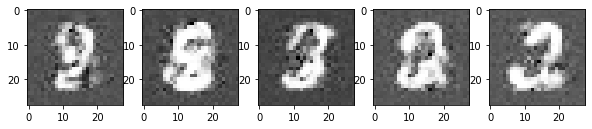

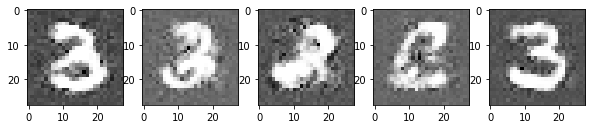

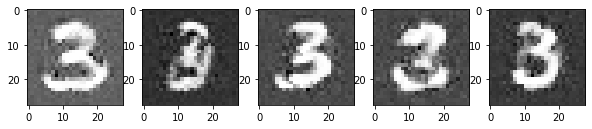

In [33]:
for _ in range(100):
    fix_z = torch.randn(5, z_dim).cuda()
    fake = G(fix_z)
    show_images(fake.detach().cpu())